**Chapter 14 – Deep Computer Vision Using Convolutional Neural Networks**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/jdecorte/ai_ml/blob/main/140-deep_computer_vision_with_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

No GPU was detected. CNNs can be very slow without a GPU.


A couple utility functions to plot grayscale and RGB images:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# What is a Convolution?

- The studie of the human visual cortex inspired researchers to an neural network architecture which gradually evolved into what we now call **convolutional neural networks**. An important milestone was a 1998. 
- This architecture has some building blocks that you already know, such as fully connected layers and sigmoid activation functions, but it also introduces two new building blocks: 
  - convolutional layers
  - pooling layers

Why not simply use a deep neural network with fully connected layers for image recognition tasks? 
- Unfortunately, although this works fine for small images (e.g., MNIST), it breaks down for larger images because of the huge number of parameters it requires. 
- For example, a 100 × 100–pixel image has 10,000 pixels, and if the first layer has just 1,000 neurons (which already severely restricts the amount of information transmitted to the next layer), this means a total of 10 million connections. And that’s just the first layer. 
- CNNs solve this problem using partially connected layers and weight sharing.

## Convolutional Layers
- Neurons in the first convolutional layer are not connected to every single pixel in the input image (like they were in the layers discussed in previous chapters), but only to pixels in their receptive fields:  
  
![](img/cnn.png)

- All the multilayer neural networks we’ve looked at so far had layers composed of a long line of neurons, and we had to flatten input images to 1D before feeding them to the neural network. 
- In a CNN each layer is represented in 2D, which makes it easier to match neurons with their corresponding inputs.
- In a CNN, each neuron in the second layer is connected only to neurons located within a small rectangle in the first layer.
- This architecture allows the network to **concentrate on small low-level features in the first hidden layer**, **then** assemble them into **larger higher-level features in the next hidden layer**, and so on.
- A neuron located in row $i$, column $j$ of a given layer is connected to the outputs of the neurons in the previous layer located in rows $i$ to $i + f_h – 1$, columns $j$ to $j + f_w – 1$, where $f_h$ and $f_w$ are the height and width of the receptive field (see figure below). 
- In order **for a layer to have the same height and width as the previous layer**, it is common to **add zeros around the inputs**, as shown in the diagram. This is called **zero padding**.

![](img/cnn_connections.png)

It is also possible to connect a large input layer to a much smaller layer by spacing out the receptive fields: 

![](img/cnn_stride.png)

- This dramatically reduces the model’s computational complexity. 
- The shift from one receptive field to the next is called the _stride_. 
- In the diagram, a 5 × 7 input layer (plus zero padding) is connected to a 3 × 4 layer, using 3 × 3 receptive fields and a stride of 2 (in this example the stride is the same
in both directions, but it does not have to be so). 
- A neuron located in row $i$, column $j$ in the upper layer is connected to the outputs of the neurons in the previous layer located in rows $i × s_w$ to $i × s_w + f – 1$, columns $j × s_h$ to $j × s_h + f – 1$, where $s_w$ and $s_h$ are the vertical and horizontal strides.

## Filters

- A neuron’s weights can be represented as a small image the size of the receptive field. 
- For example, the figure below shows two possible sets of weights, called filters (or convolution kernels). 
- The first one is represented as a black square with a vertical white line in the middle (it is a 7 × 7 matrix full of 0s except for the central column, which is full of 1s)
  - neurons using these weights will ignore everything in their receptive field except for the central vertical line (since all inputs will get multiplied by 0, except for the ones located in the central vertical line). 
- The second filter is a black square with a horizontal white line in the middle. 
  - neurons using these weights will ignore everything in their receptive field except for the central horizontal line.

![](img/cnn_filters.png)

- Now if all neurons in a layer use the same vertical line filter (and the same bias term), and you feed the network the input image shown in the figure (the bottom image), the layer will output the top-left image. 
  - notice that the vertical white lines get enhanced while the rest gets blurred. 
- Similarly, the upper-right image is what you get if all neurons use the same horizontal line filter
  - notice that the horizontal white lines get enhanced while the rest is blurred out. 
- Thus, a layer full of neurons using the same filter outputs a **feature map**, which highlights the areas in an image that activate the filter the most. 
- Of course, **you do not have to define the filters manually**: instead, **during training the convolutional layer will automatically learn the most useful filters** for its task, and the layers above will learn to combine them into more complex patterns. 

## Stacking Multiple Feature maps
- Up to now, for simplicity, we have represented the output of each convolutional layer as a 2D layer.
- In reality a convolutional layer has multiple filters (you decide how many) and outputs one feature map per filter, so it is more accurately represented in 3D:

![](img/cnn_stacking.png)

- Specifically, a neuron located in row $i$, column $j$ of the feature map $k$ in a given convolutional layer $l$ is connected to the outputs of the neurons in the previous layer $l – 1$, located in rows $i × s_h$ to $i × s_h + f – 1$ and columns $j × s_w$ to $j × s_w + f – 1$, across all feature maps (in layer $l – 1$).
- Note that all neurons located in the same row $i$ and column $j$ but in different feature maps are connected to the outputs of the exact same neurons in the previous layer.
- Each CNN layer has one neuron per pixel in each feature map, and all neurons within a given feature map share the same parameters (i.e., the same weights and bias term). 
- Neurons in different feature maps use different parameters.
- **The fact that all neurons in a feature map share the same parameters dramatically reduces the number of parameters in the model**. 
- Once the CNN has learned to recognize a pattern in one location, it can recognize it in any other location. 
- In contrast, once a regular DNN has learned to recognize a pattern in one location, it can recognize it only in that particular location.
- Thus, a convolutional layer simultaneously applies multiple trainable filters to its inputs, making it capable of detecting multiple features anywhere in its inputs.










## Convolutional Layers in Keras

Let's now create a 2D convolutional layer, using the high-level API `keras.layers.Conv2D()` on two sample images:

(2, 427, 640, 3)


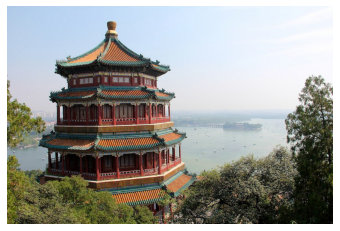

In [10]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255       # load a color image and scale
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])

print(images.shape)
plt.imshow(china) # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

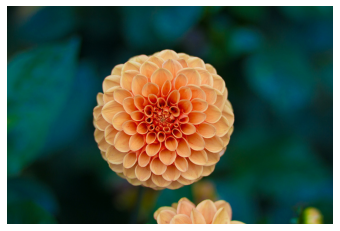

In [11]:
plt.imshow(flower) # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                           padding="SAME", activation="relu", input_shape=[2, 427, 640, 3])

In [13]:
conv_outputs = conv(images)
conv_outputs.shape 

TensorShape([2, 427, 640, 2])

The output is a 4D tensor. The dimensions are: batch size, height, width, channels. The first dimension (batch size) is 2 since there are 2 input images. The next two dimensions are the height and width of the output feature maps: since `padding="SAME"` and `strides=1`, the output feature maps have the same height and width as the input images (in this case, 427×640). Lastly, this convolutional layer has 2 filters, so the last dimension is 2: there are 2 output feature maps per input image.

Since the filters are initialized randomly, they'll initially detect random patterns. Let's take a look at details of the 2 output features maps for each image:

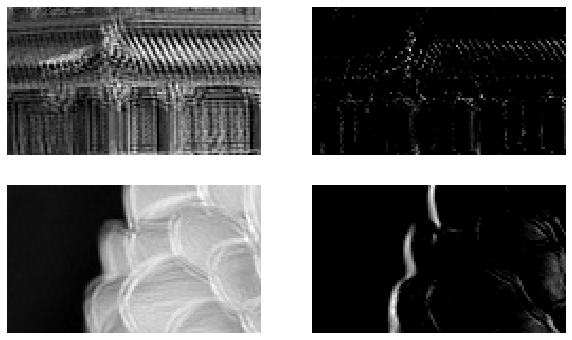

In [14]:
def crop(images):
    return images[150:220, 130:250]

plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

- Although the filters were initialized randomly, the second filter happens to act like an edge detector. 
- Randomly initialized filters often act this way, which is quite fortunate since detecting edges is quite useful in image processing.

## Memory Requirements

- Another problem with CNNs is that the **convolutional layers require a huge amount of RAM**, especially true **during training**, because the reverse pass of backpropagation requires all the intermediate values computed during the forward pass.
- For example, **consider a convolutional layer with 5 × 5 filters, outputting 200 feature maps of size 150 × 100, with stride 1 and "same" padding**. 
  - If the **input is a 150 × 100 RGB image** (three channels), then the number of parameters is (5 × 5 × 3 + 1) × 200 = 15,200 (the + 1 corresponds to the bias terms), which is fairly small compared to a fully connected layer.
  - However, each of the 200 feature maps contains 150 × 100 neurons, and each of these neurons needs to compute a weighted sum of its 5 × 5 × 3 = 75 inputs: that’s a total of 225 million float multiplications. 
  - Not as bad as a fully connected layer, but still quite computationally intensive. 
  - Moreover, if the feature maps are represented using 32-bit floats, then the convolutional layer’s output will occupy 200 × 150 × 100 × 32 = 96 million bits (12 MB) of RAM. And that’s just for one instance—**if a training batch contains 100 instances, then this layer will use up 1.2 GB of RAM!**
  - **During training everything computed during the forward pass needs to be preserved for the reverse pass, so the amount of RAM needed is (at least) the total amount of RAM required by all layers**.

# Pooling layers

- Now let’s look at the second common building block of CNNs: the _pooling layer_.
- Their goal is to subsample (i.e., shrink) the input image in order to reduce the computational load, the memory usage, and the number of parameters (thereby limiting the risk of overfitting).
- Just like in convolutional layers, each neuron in a pooling layer is connected to the outputs of a limited number of neurons in the previous layer, located within a small Rectangular receptive field. 
- You must define its size, the stride, and the padding type, just like before. 
- However, **a pooling neuron has no weights; all it does is aggregate the inputs using an aggregation function such as the max or mean**.
- This figure shows a max pooling layer, which is the most common type of pooling layer: 

![](img/pooling.png)

- In this example, we use a $2 × 2$ _pooling kernel_, with a stride of 2 and no padding.
- Because of the stride of 2, the output image has half the height and half the width of the input image (rounded down since we use no padding).

#### Advantages of pooling layers
- reducing 
  - computations
  - memory usage
  - number of parameters
- introduces some level of _invariance_ to small translations:  

![](img/pooling_translations.png)

- The outputs of the max pooling layer for images A and B are identical = translation invariance
- For image C, the output is different: it is shifted one pixel to the right. 
- By **inserting a max pooling layer every few layers in a CNN**, it is possible to get some level of **translation invariance at a larger scale**. 
- Moreover, max pooling offers a **small amount of rotational invariance** and a **slight scale invariance**. 
- Such invariance (even if it is limited) can be useful in cases where the prediction should not depend on these details, such as in classification tasks.
- Of course, max pooling is very destructive, which can be a drawback.


## Max pooling in keras

In [18]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [19]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)  # see function crop() above
output = max_pool(cropped_images)

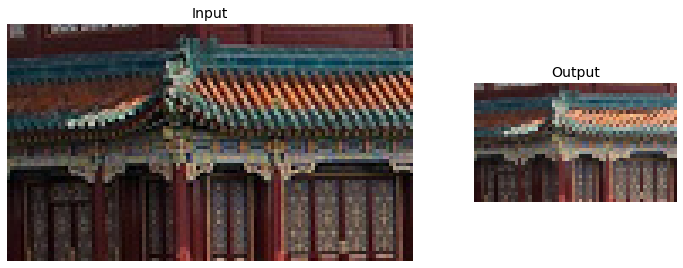

In [20]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

## Average pooling

- Works exactly like a max pooling layer, except it computes the mean rather than the max. 
- Average pooling layers used to be very popular, but people mostly use **max pooling** layers now, as they **generally perform better**. 
- This may seem surprising, since computing the mean generally loses less information than computing the max. 
- But on the other hand, **max pooling preserves only the strongest features**, getting rid of all the meaningless ones, so the next layers get a cleaner signal to work with. 
- Moreover, **max pooling offers stronger translation invariance than average pooling**, and it requires slightly less compute.

In [21]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [22]:
output_avg = avg_pool(cropped_images)

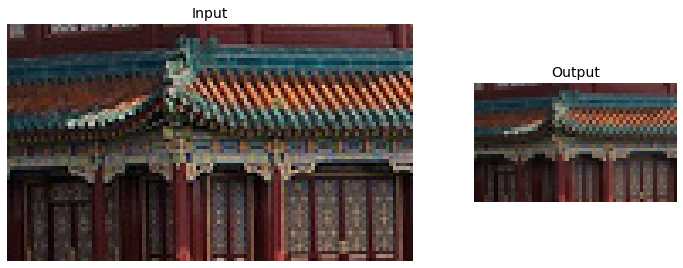

In [23]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

## CNN Architectures

- Typical CNN architectures stack a few convolutional layers (each one generally followed by a ReLU layer), then a pooling layer, then another few convolutional layers (+ReLU), then another pooling layer, and so on.
- **The image gets smaller and smaller as it progresses through the network, but it also typically gets deeper and deeper** (i.e., with more feature maps), thanks to the convolutional layers:
![](img/cnn_architecture.png)

- **At the top of the stack, a regular feedforward neural network is added, composed of a few fully connected layers (+ReLUs)**, and the final layer outputs the prediction (e.g., a softmax layer that outputs estimated class probabilities).

**TIP**

- **A common mistake is to use convolution kernels that are too large**. 
- For example, instead of using a convolutional layer with a 5 × 5 kernel, stack two layers with 3 × 3 kernels: it  will use fewer parameters and require fewer computations, and it will usually perform better. 
- One exception is for the first convolutional layer: it can typically have a large kernel (e.g., 5 × 5), usually with a stride of 2 or more: this will reduce the spatial dimension of the image without losing too much information, and since the input image only has three channels in general, it will not be too costly.

# Tackling Fashion MNIST With a CNN

In [24]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.


In [25]:
'''
You can create partial functions in python by using the partial function from the functools library. 
Partial functions allow one to derive a function with x parameters to a function with fewer parameters and fixed values set for the more limited function. 
(see https://www.learnpython.org/en/Partial_functions#:~:text=You%20can%20create%20partial%20functions,for%20the%20more%20limited%20function.&text=This%20code%20will%20return%208.)
'''

from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [26]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 127s 74ms/step - loss: 0.7094 - accuracy: 0.7468 - val_loss: 0.3517 - val_accuracy: 0.8712
Epoch 2/10
1719/1719 [==============================] - 131s 76ms/step - loss: 0.4131 - accuracy: 0.8590 - val_loss: 0.2999 - val_accuracy: 0.8922
Epoch 3/10
1719/1719 [==============================] - 126s 73ms/step - loss: 0.3541 - accuracy: 0.8782 - val_loss: 0.2815 - val_accuracy: 0.8976
Epoch 4/10
1719/1719 [==============================] - 126s 73ms/step - loss: 0.3129 - accuracy: 0.8915 - val_loss: 0.2627 - val_accuracy: 0.9088
Epoch 5/10
1719/1719 [==============================] - 126s 73ms/step - loss: 0.2939 - accuracy: 0.8983 - val_loss: 0.2556 - val_accuracy: 0.9112
Epoch 6/10
1719/1719 [==============================] - 132s 77ms/step - loss: 0.2725 - accuracy: 0.9049 - val_loss: 0.2483 - val_accuracy: 0.9092
Epoch 7/10
1719/1719 [==============================] - 132s 77ms/step - loss: 0.2535 - accuracy: 0.9116 - val_loss: 0

In [27]:
model.evaluate(X_test, y_test)

  1/313 [..............................] - ETA: 10s - loss: 0.6873 - accuracy: 0.9062

313/313 [==============================] - 7s 23ms/step - loss: 0.2871 - accuracy: 0.9087


[0.2871140241622925, 0.9086999893188477]

- This CNN reaches over 91 % accuracy on the test set, clearly much better than what we achieved with dense networks in Chapter 10 (88,6 %).
- Over the years, variants of this fundamental architecture have been developed, leading to amazing advances in the field. 
- A good measure of this progress is the error rate in competitions such as the ILSVRC ImageNet challenge. 
- In this competition the top-five error rate for image classification fell from over 26% to less than 2.3% in just six years. The top-5 error rate is the percentage of test images for which the right label is not among the model's top five most likely labels. 
- The images are large (256 pixels high) and there are 1,000 classes, some of which are really subtle (try distinguishing 120 dog breeds). 
- Looking at the evolution of the winning entries is a good way to understand how CNNs work.
- The most basic ones are LeNet-5 and AlexNet:

### LeNet-5

![](img/lenet.png)


### AlexNet

![](img/alexnet.png)
